# Data Access Methods

**Marty Hidas**

**Australian Ocean Data Network ([AODN](https://imos.org.au/facilities/aodn))**



This tutorial demostrates several ways data can be accessed remotely and loaded into a Python environment, including

* OPeNDAP
* OGC Web Feature Service (WFS)
* direct access to files on cloud storage (AWS S3)
* cloud-optimised formats Zarr & Parquet

The examples here use data from Australia's Integrated Marine Observing System (IMOS).
These can be browsed and accessed via the [AODN Portal](https://portal.aodn.org.au/), the [IMOS Metadata Catalogue](https://catalogue-imos.aodn.org.au/), or the [IMOS THREDDS Server](https://thredds.aodn.org.au/thredds/catalog/IMOS/catalog.html). Each data collection's metadata record includes more specific links to the relevant THREDDS folders, and WFS services.


## Install Python packages
These are the packages we'll be using in this tutorial. You only need to run this once when you first run the notebook in your environment. You will need to restart your session before you can import these new packages.


In [ ]:
%pip install pandas netcdf4 xarray dask owslib s3fs holoviews hvplot geoviews cartopy


Note: for the purpose of this notebook you can safely ignore the following error you might see:
```bash
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
```

## Import packages

In [ ]:
# Import all the tools we need...
import os

# For working with data
import pandas as pd
import xarray as xr

# For data that may be larger than the memory available on your computer...
import dask
import dask.dataframe as dd

# For accessing OGC Web Feature Service
from owslib.wfs import WebFeatureService

# For accessing AWS S3 cloud storage
import s3fs

# Plotting tools
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

# For plotting geographic data & maps
import geoviews as gv
import geoviews.feature as gf
from geoviews import opts
from cartopy import crs

## Use Matplotlib backend for web preview of notebook
## Comment out these lines to get the default interactive plots using Bokeh
hvplot.extension('matplotlib', compatibility='bokeh')
gv.extension('matplotlib')
gv.output(size=200)

# The old school way

The old (and still common) way to access data is to first download it to your computer and read it from there.
This is easy for small datasets, but not always ideal:
* What if the data is bigger than your hard disk?
* What if you only need a small fraction of a dataset?
* What if the dataset is routinely updated and you want to re-run your analysis on the latest data?
* What if you want to run your analysis on another computer or in the cloud?

These days it is often more convenient to have data managed in a central location and access it remotely.
There are many ways this can be done. In this tutorial we will look at a few of the common ones, and some of the newer ones.

# OPeNDAP

* [OPeNDAP](https://www.opendap.org/about) stands for "Open-source Project for a Network Data Access Protocol"
* Provides access to metadata and data subsets via the Web without downloading an entire dataset
* Many tools that can read NetCDF files can also talk to an OPeNDAP URL directly

In Python, we can simply open the URL with `xarray`, then proceed with our analysis using the resulgting `Dataset` object.

Here we use an example from the [AODN THREDDS server](https://thredds.aodn.org.au/thredds/catalog.html).

In [3]:
opendap_url = ("https://thredds.aodn.org.au/thredds/dodsC/"
               "IMOS/ANMN/NSW/PH100/gridded_timeseries/"
               "IMOS_ANMN-NSW_TZ_20091029_PH100_FV02_TEMP-gridded-timeseries_END-20231218_C-20240106.nc")

# You can preview the file's metadata in your browser by adding ".html" to the above URL
print(opendap_url + ".html")

https://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NSW/PH100/gridded_timeseries/IMOS_ANMN-NSW_TZ_20091029_PH100_FV02_TEMP-gridded-timeseries_END-20231218_C-20240106.nc.html


In [4]:
ds_mooring = xr.open_dataset(opendap_url)
ds_mooring

<xarray.Dataset>
Dimensions:     (TIME: 121698, DEPTH: 12)
Coordinates:
  * DEPTH       (DEPTH) float32 0.0 10.0 20.0 30.0 ... 80.0 90.0 100.0 110.0
  * TIME        (TIME) datetime64[ns] 2009-10-29T03:00:00 ... 2023-12-18T01:0...
    LONGITUDE   float64 ...
    LATITUDE    float64 ...
Data variables:
    TEMP_count  (TIME) int16 ...
    TEMP        (TIME, DEPTH) float32 ...
Attributes: (12/42)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Gridded Time Series Product: This file con...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Ocean Data Network (AODN)
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    source_file_download:          https://s3-ap-southeast-2.amazonaws.com/im...
    source_file_opendap:           http://thredds.aodn.org.au/thredds/dodsC/I...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2023-12-18T01:00:00Z
    time_coverage_start:           2009-10-29T03:00:00Z
    title:                         Gridded Time Series Product: TEMP interpol...

In [5]:
from pprint import pprint

pprint(ds_mooring.title)
pprint(ds_mooring.abstract)

('Gridded Time Series Product: TEMP interpolated at PH100 to fixed target '
 'depths at 1-hour time intervals, between 2009-10-29T03:00:00Z and '
 '2023-12-18T01:00:00Z and 0 and 110 meters.')
('Gridded Time Series Product: This file contains TEMP readings from all '
 'instruments deployed at the PH100 mooring site. The source of the values is '
 'the Hourly Time Series Product where TIME is fixed to 1-hour interval. The '
 'variable values are interpolated to a fixed target depths using a linear '
 'interpolation between consecutive existing depths. Only values flagged as 1 '
 'or 2 are used in the interpolation.')


This dataset is derived from repeated deployments of moored temperature loggers, binned to hourly intervals and interpolated to a fixed set of target depths. See the file metadata, or the associated [metadata record](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/279a50e3-21a5-4590-85a0-71f963efab82) for more info.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Scatter   [TIME]   (DEPTH,TEMP)
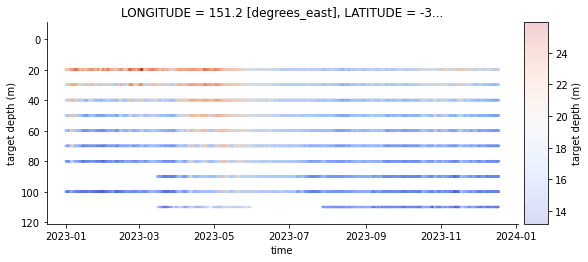

In [6]:
# Hourly averages x 12 depths x 13+ yr = over a million points to plot!
# Let's just look at a year's worth to speed things up...

ds_mooring.sel(TIME="2023").hvplot.scatter(x="TIME", y="DEPTH", c="TEMP",
                                           cmap="coolwarm", alpha=0.2,
                                           flip_yaxis=True, hover=False)

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Curve   [TIME]   (TEMP)
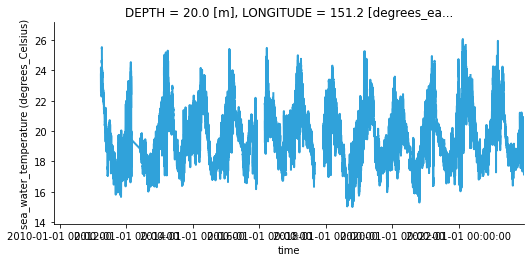

In [7]:
# ... or we can look at the full timeseries of temperature at a single depth
ds_mooring.TEMP.sel(DEPTH=20).hvplot()

### Another example
See also the OPeNDAP example in [this tutorial](https://github.com/oceanhackweek/ohw-tutorials/blob/OHW22/01-Tue/00-data-access-in-python/00-data-access.ipynb) from OceanHackWeek 2022, or explore that [dataset](http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best.html) in the OPeNDAP Access Form.

# Web Feature Service (WFS)

* A [standard](http://www.opengeospatial.org/standards/wfs) of the [Open Geospatial Consortium](http://www.opengeospatial.org/) (OGC)
* Allows tabular geospatial data to be accessed via the Web.
* A _feature_ has a _geometry_ (e.g. a point/line/polygon) indicating a geographic location, and a set of properties (e.g. temperature)
* WFS allows filtering based on geometry or properties.
* In Python WFS and other OGC Web Services (OWS) can be accessed using the [`owslib`](https://pypi.org/project/OWSLib/) library

For example, most of the tabular hosted by the AODN is available via WFS.

In [8]:
wfs = WebFeatureService(url="https://geoserver-123.aodn.org.au/geoserver/wfs",
                        version="1.1.0")
wfs.identification.title

'AODN Web Feature Service (WFS)'

In [9]:
# Each dataset is served as a separate "feature type":
print(f"There are {len(wfs.contents)} fature types, e.g.")
list(wfs.contents)[:10]

There are 398 fature types, e.g.


['imos:anmn_ctd_profiles_data',
 'imos:anmn_ctd_profiles_map',
 'imos:anmn_velocity_timeseries_map',
 'imos:anmn_nrs_rt_meteo_timeseries_data',
 'imos:anmn_nrs_rt_meteo_timeseries_map',
 'imos:anmn_nrs_rt_bio_timeseries_data',
 'imos:anmn_nrs_rt_bio_timeseries_map',
 'imos:anmn_nrs_rt_wave_timeseries_data',
 'imos:anmn_nrs_rt_wave_timeseries_map',
 'imos:anmn_acoustics_map']

For now we'll assume we already know which featuretype we want. In this example we'll look at a dataset containing condicutivity-temperature-depth (CTD) profiles obtained at the National Reference Stations around Australia ([here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/7b901002-b1dc-46c3-89f2-b4951cedca48)'s a detailed metadata record)

In [10]:
typename = 'imos:anmn_ctd_profiles_data'
wfs.get_schema(typename)['properties']

{'file_id': 'int',
 'site_code': 'string',
 'cruise_id': 'string',
 'time_coverage_start': 'dateTime',
 'time_coverage_end': 'dateTime',
 'TIME': 'dateTime',
 'INSTANCE': 'int',
 'DIRECTION': 'string',
 'TIME_quality_control': 'string',
 'LATITUDE': 'double',
 'LATITUDE_quality_control': 'string',
 'LONGITUDE': 'double',
 'LONGITUDE_quality_control': 'string',
 'DEPTH': 'float',
 'DEPTH_quality_control': 'string',
 'BOT_DEPTH': 'float',
 'BOT_DEPTH_quality_control': 'string',
 'PRES_REL': 'float',
 'PRES_REL_quality_control': 'string',
 'TEMP': 'float',
 'TEMP_quality_control': 'string',
 'PSAL': 'float',
 'PSAL_quality_control': 'string',
 'DOX2': 'float',
 'DOX2_quality_control': 'string',
 'TURB': 'float',
 'TURB_quality_control': 'string',
 'CHLF': 'float',
 'CHLF_quality_control': 'string',
 'CHLU': 'float',
 'CHLU_quality_control': 'string',
 'CPHL': 'float',
 'CPHL_quality_control': 'string',
 'CNDC': 'float',
 'CNDC_quality_control': 'string',
 'DESC': 'float',
 'DESC_quality_c

We can read in a subset of the data by specifying a bounding box (in this case near Sydney, Australia).
We'll get the result in CSV format so it's easy to read into a Pandas DataFrame.

First we'll ask for just 10 features, for a quick look at the data.

In [11]:
xmin, xmax = 151.2, 151.25   # Port Hacking, near Sydney, NSW
ymin, ymax = -34.2, -34.1

response = wfs.getfeature(typename=typename,
                          bbox=(xmin, ymin, xmax, ymax),
                          maxfeatures=10,
                          outputFormat='csv')
df = pd.read_csv(response)
response.close()

df

,FID,file_id,site_code,cruise_id,time_coverage_start,time_coverage_end,TIME,INSTANCE,DIRECTION,TIME_quality_control,...,CHLU_quality_control,CPHL,CPHL_quality_control,CNDC,CNDC_quality_control,DESC,DESC_quality_control,DENS,DENS_quality_control,geom
0,anmn_ctd_profiles_data.fid-75d89921_18f4c51a02...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6266,0,0.228,0,1025.8478,0,POINT (-34.1161666667 151.218)
1,anmn_ctd_profiles_data.fid-75d89921_18f4c51a02...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6246,0,0.574,0,1025.8652,0,POINT (-34.1161666667 151.218)
2,anmn_ctd_profiles_data.fid-75d89921_18f4c51a02...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6224,0,0.741,0,1025.8737,0,POINT (-34.1161666667 151.218)
3,anmn_ctd_profiles_data.fid-75d89921_18f4c51a02...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6190,0,0.803,0,1025.8790,0,POINT (-34.1161666667 151.218)
4,anmn_ctd_profiles_data.fid-75d89921_18f4c51a02...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6138,0,0.749,0,1025.8892,0,POINT (-34.1161666667 151.218)
5,anmn_ctd_profiles_data.fid-75d89921_18f4c51a02...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6089,0,0.687,0,1025.9072,0,POINT (-34.1161666667 151.218)
6,anmn_ctd_profiles_data.fid-75d89921_18f4c51a02...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6067,0,0.722,0,1025.9241,0,POINT (-34.1161666667 151.218)
7,anmn_ctd_profiles_data.fid-75d89921_18f4c51a02...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6048,0,0.773,0,1025.9321,0,POINT (-34.1161666667 151.218)
8,anmn_ctd_profiles_data.fid-75d89921_18f4c51a02...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.6023,0,0.788,0,1025.9385,0,POINT (-34.1161666667 151.218)
9,anmn_ctd_profiles_data.fid-75d89921_18f4c51a02...,754,PH100,PHNRS_1108,2011-08-29T00:03:40,2011-08-29T00:03:40,2011-08-29T00:03:40,NaN,D,NaN,...,NaN,NaN,NaN,4.5982,0,0.846,0,1025.9432,0,POINT (-34.1161666667 151.218)


We can also filter the data based on the values in specified columns (properties) and ask for only a subset of the columns to be returned. The filters need to be provided in XML format, but the `owslib` library allows us to construct them in a more Pythonic way.

Here we select only the profiles associated with the Port Hacking 100m mooring site, and only the data points flagged as "good data" by automated quality-control procedures.

In [12]:
from owslib.etree import etree
from owslib.fes import PropertyIsEqualTo, And

filter = And([PropertyIsEqualTo(propertyname="site_code", literal="PH100"),
              PropertyIsEqualTo(propertyname="PRES_REL_quality_control", literal="1"),
              PropertyIsEqualTo(propertyname="TEMP_quality_control", literal="1"),
              PropertyIsEqualTo(propertyname="PSAL_quality_control", literal="1"),
              PropertyIsEqualTo(propertyname="CPHL_quality_control", literal="1")
             ])
filterxml = etree.tostring(filter.toXML(), encoding="unicode")

response = wfs.getfeature(typename=typename, filter=filterxml, outputFormat="csv",
                          propertyname=["TIME", "DEPTH", "TEMP", "PSAL", "CPHL"]
                         )
df = pd.read_csv(response, parse_dates=["TIME"])
response.close()

# the server adds a feature ID column we don't really need
df.drop(columns='FID', inplace=True)

df

,TIME,DEPTH,TEMP,PSAL,CPHL
0,2014-12-08 22:28:54,1.986,21.6432,35.5080,0.9365
1,2014-12-08 22:28:54,2.979,21.6441,35.5085,0.9560
2,2014-12-08 22:28:54,3.971,21.6417,35.5085,0.9644
3,2014-12-08 22:28:54,4.964,21.6314,35.5089,0.9963
4,2014-12-08 22:28:54,5.957,21.6077,35.5102,0.9844
...,...,...,...,...,...
11742,2024-01-30 21:16:08,15.885,21.1410,35.4467,4.4055
11743,2024-01-30 21:16:08,16.878,20.9477,35.4476,4.2312
11744,2024-01-30 21:16:08,17.871,20.5730,35.4474,4.4226
11745,2024-01-30 21:16:08,18.864,20.2551,35.4441,4.4341


/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:Layout
   .NdOverlay.I   :NdOverlay   [TIME]
      :Curve   [TEMP]   (DEPTH)
   .NdOverlay.II  :NdOverlay   [TIME]
      :Curve   [PSAL]   (DEPTH)
   .NdOverlay.III :NdOverlay   [TIME]
      :Curve   [CPHL]   (DEPTH)
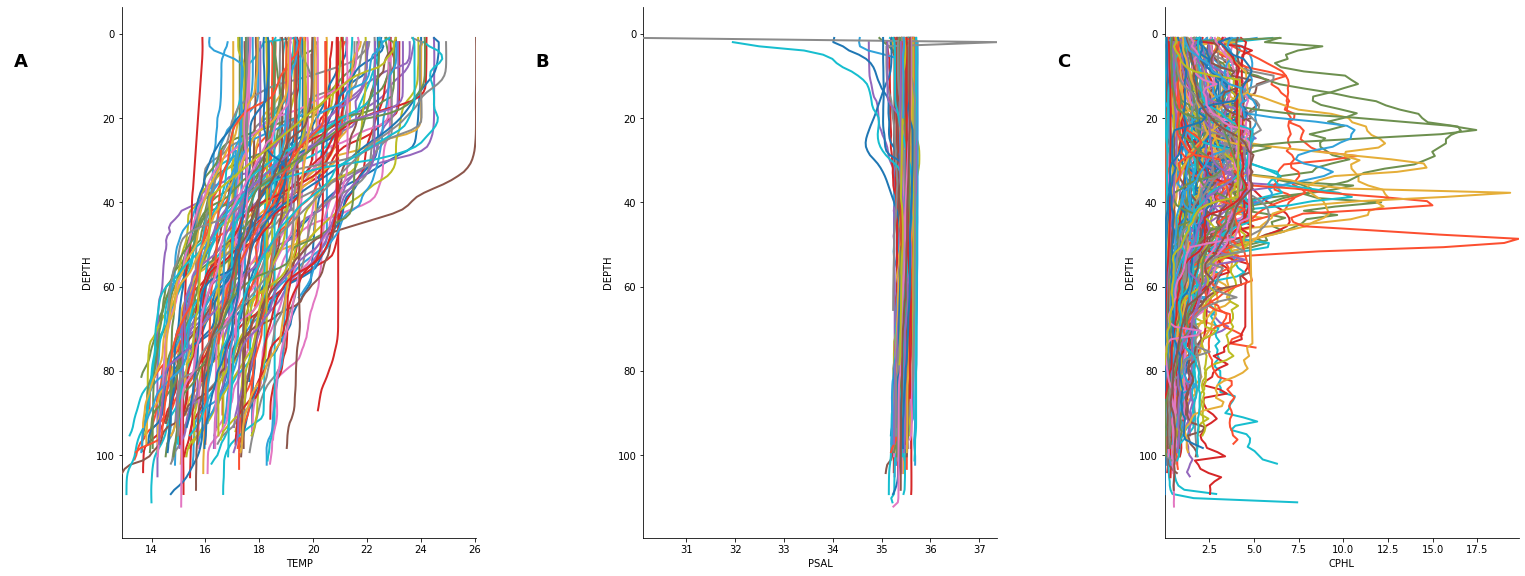

In [13]:
# We can explore the temperature, salinity and chlorophyll profiles
# Change "by" to "groupby" to view one profile at a time, with time selected interactively
temp_plot = df.hvplot(x="TEMP", y="DEPTH", by="TIME", flip_yaxis=True, legend=False, width=200)
psal_plot = df.hvplot(x="PSAL", y="DEPTH", by="TIME", flip_yaxis=True, legend=False, width=200)
cphl_plot = df.hvplot(x="CPHL", y="DEPTH", by="TIME", flip_yaxis=True, legend=False, width=200)

(temp_plot + psal_plot + cphl_plot).opts(tight=True)

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .Curve.I   :Curve   [TIME]   (TEMP)
   .Scatter.I :Scatter   [TIME]   (TEMP)
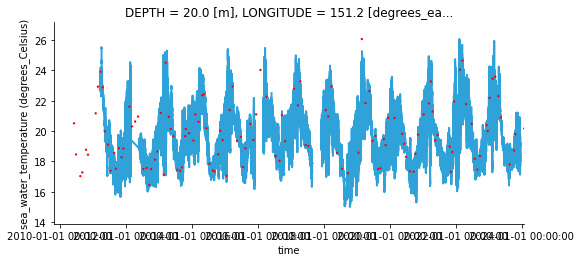

In [14]:
# We can also extract the temperature measurements at a fixed depth
# and compare to the timeseries from the mooring
comp_depth = 20  # metres

df_sub = df[df.DEPTH.round() == comp_depth]
ctd_plot = df_sub.hvplot.scatter(x="TIME", y="TEMP", c="red")

mooring_plot = ds_mooring.TEMP.sel(DEPTH=comp_depth).hvplot()

mooring_plot * ctd_plot

# Direct access to files on cloud storage

Data files made available to the public on cloud storage such as [Amazon S3](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html) (Simple Storage Service) can be accessed over the web as if they were stored locally. You just need to find the exact URL for each file.

In Python, we can access S3 storage in a very similar way to a local filesystem using the `s3fs` library.

For example, all the public data files hosted by the Australian Ocean Data Network are stored in an [S3 bucket](https://www.techtarget.com/searchaws/definition/AWS-bucket) called `imos-data`. You can browse the contents of the bucket and download individual files [here](https://imos-data.aodn.org.au).

Below we'll look at a [high-resolution regional SST product](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/a4170ca8-0942-4d13-bdb8-ad4718ce14bb) from IMOS (based on satellite and in-situ observations). This product is a collection of daily gridded NetCDF files covering the Australian region.

In [15]:
s3 = s3fs.S3FileSystem(anon=True)

# List the most recent files available
sst_files = s3.ls("imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024")
sst_files[-20:]

['imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024/20240415120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024/20240416120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024/20240417120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024/20240418120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024/20240419120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024/20240420120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024/20240421120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024/20240422120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024/202404231

In [16]:
# Open the latest file and look at its contents
ds = xr.open_dataset(s3.open(sst_files[-1]))

# Need this to turn off interactive ('html') display of xarray Dataset to avoid
# an error caused by the encoding in some attributes in the dataset
# see https://github.com/pydata/xarray/issues/6511
xr.set_options(display_style='text', display_width=120)

ds

<xarray.Dataset>
Dimensions:           (time: 1, lat: 1081, lon: 1561)
Coordinates:
  * time              (time) datetime64[ns] 2024-05-04T12:00:00
  * lat               (lat) float32 -70.0 -69.92 -69.83 -69.75 -69.67 -69.58 ... 19.58 19.67 19.75 19.83 19.92 20.0
  * lon               (lon) float32 60.0 60.08 60.17 60.25 60.33 60.42 60.5 ... 189.6 189.7 189.8 189.8 189.9 190.0
Data variables:
    sea_ice_fraction  (time, lat, lon) float32 ...
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    crs               int32 ...
Attributes: (12/65)
    id:                         RAMSSA_09km-ABOM-L4-AUS-v01
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    title:                      RAMSSA v1.1 Analysed high resolution foundation sea surface temperature over Australi...
    summary:                    AMSR2-JAXA nobs=****** obsesd: avg=0.693 min=0.700 max= 0.700, AVHRRMTB_G-NAVO nobs=1...
    source:                     AMSR2-JAXA,AVHRRMTB_G-NAVO,VIIRS_NPP_OSPO,VIIRS_N20_OSPO,IN_SITU-GTS_BUOYS,IN_SITU-GT...
    references:                 Beggs H., A. Zhong, G. Warren, O. Alves, G. Brassington and T. Pugh (2011)  RAMSSA  A...
    ...                         ...
    geospatial_lat_max:         20.0
    geospatial_lat_min:         -70.0
    geospatial_lon_max:         190.0
    geospatial_lon_min:         60.0
    geospatial_bounds:          POLYGON((-70 60, 20 60, 20 190, -70 190, -70 60))
    geospatial_bounds_crs:      EPSG:4326

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


:Overlay
   .Image.I :Image   [lon,lat]   (analysed_sst)
   .Land.I  :Feature   [Longitude,Latitude]
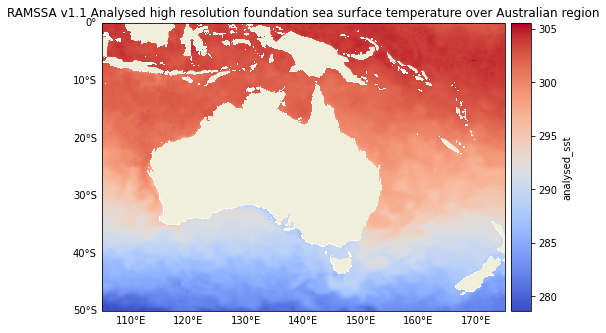

In [17]:
# Plot a subset of the dataset around Australia
sst_var = 'analysed_sst'
gds = gv.Dataset(ds.sel(lat=slice(-50, 0), lon=slice(105, 175)),
                 kdims=['lon', 'lat'],
                 vdims=[sst_var]
                )
sst_plot = (gds.to(gv.Image)
               .opts(cmap='coolwarm', colorbar=True, aspect=1.4, title=ds.title))
sst_plot * gf.land

It's worth understanding a little about how this works.

The above example only makes use of the metadata from the file, one of the 4 data variables, and the `lon` and `lat` coordinates. On a local filesystem, it would be easy to read only these specific parts of the file from disk.

However, on cloud storage services like S3 (also called "object storage") the basic read/write functions operate on the entire file (object), so at least in the backend, the entire file is read**. If you only need a small subset of a large file, this can be a very inefficient way to get it.

** _Note: it is possible to request only a subset of an S3 object to be read, but this is more advanced usage than what we're doing here._

For example, if we wanted to plot a timeseries of the above satellite SST product at a given point, we would only need a single value out of each file (corresponding to one point in the timeseries), but the entire file would need to be read each time.

For a quick demo we'll try this with last month's files. `xarray` has a handy `open_mfdataset` function that can create a single `Dataset` object out of a series of files (with similar structure).

In [18]:
%%time
s3_objs = [s3.open(f)
           for f in s3.glob("imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2024/202404*")
          ]
mds = xr.open_mfdataset(s3_objs, engine="h5netcdf")
mds

CPU times: user 13.6 s, sys: 876 ms, total: 14.5 s
Wall time: 22.4 s


<xarray.Dataset>
Dimensions:           (time: 30, lat: 1081, lon: 1561)
Coordinates:
  * time              (time) datetime64[ns] 2024-04-01T12:00:00 2024-04-02T12:00:00 ... 2024-04-30T12:00:00
  * lat               (lat) float32 -70.0 -69.92 -69.83 -69.75 -69.67 -69.58 ... 19.58 19.67 19.75 19.83 19.92 20.0
  * lon               (lon) float32 60.0 60.08 60.17 60.25 60.33 60.42 60.5 ... 189.6 189.7 189.8 189.8 189.9 190.0
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
    crs               (time) float64 -2.147e+09 -2.147e+09 -2.147e+09 -2.147e+09 ... -2.147e+09 -2.147e+09 -2.147e+09
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 1081, 1561), meta=np.ndarray>
Attributes: (12/65)
    id:                         RAMSSA_09km-ABOM-L4-AUS-v01
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    title:                      RAMSSA v1.1 Analysed high resolution foundation sea surface temperature over Australi...
    summary:                    AMSR2-JAXA nobs=982904 obsesd: avg=0.693 min=0.700 max= 0.700, VIIRS_NPP_OSPO nobs= 3...
    source:                     AMSR2-JAXA,VIIRS_NPP_OSPO,VIIRS_N20_OSPO,IN_SITU-GTS_BUOYS,IN_SITU-GTS_BATHY,IN_SITU-...
    references:                 Beggs H., A. Zhong, G. Warren, O. Alves, G. Brassington and T. Pugh (2011)  RAMSSA  A...
    ...                         ...
    geospatial_lat_max:         20.0
    geospatial_lat_min:         -70.0
    geospatial_lon_max:         190.0
    geospatial_lon_min:         60.0
    geospatial_bounds:          POLYGON((-70 60, 20 60, 20 190, -70 190, -70 60))
    geospatial_bounds_crs:      EPSG:4326

The variables in the dataset are not loaded into memory (they're still `dask.array`s). However, in the background, each complete file had to be downloaded from S3 before the metadata needed by `open_mfdataset` could be read.

In [22]:
# View details of our SST variable
xr.set_options(display_style='html')
mds[sst_var]

<xarray.DataArray 'analysed_sst' (time: 30, lat: 1081, lon: 1561)>
dask.array<where, shape=(30, 1081, 1561), dtype=float32, chunksize=(2, 1081, 1561), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2024-04-01T12:00:00 2024-04-02T12:00:00 ... 2024-04-29T12:00:00 2024-04-30T12:00:00
  * lat      (lat) float32 -70.0 -69.92 -69.83 -69.75 -69.67 -69.58 -69.5 ... 19.5 19.58 19.67 19.75 19.83 19.92 20.0
  * lon      (lon) float32 60.0 60.08 60.17 60.25 60.33 60.42 60.5 60.58 ... 189.5 189.6 189.7 189.8 189.8 189.9 190.0
Attributes:
    valid_min:              -300
    valid_max:              4500
    units:                  kelvin
    long_name:              analysed sea surface temperature
    standard_name:          sea_surface_foundation_temperature
    comment:                Optimally interpolated analysis of SST observations.
    source:                 AMSR2-JAXA,VIIRS_NPP_OSPO,VIIRS_N20_OSPO,IN_SITU-GTS_BUOYS,IN_SITU-GTS_BATHY,IN_SITU-GTS_...
    coverage_content_type:  physicalMeasurement
    grid_mapping:           crs

We can now plot this multi-file dataset the same way as any other `xarray.Dataset`.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


CPU times: user 1.59 s, sys: 42.5 ms, total: 1.63 s
Wall time: 994 ms


:Curve   [time]   (analysed_sst)
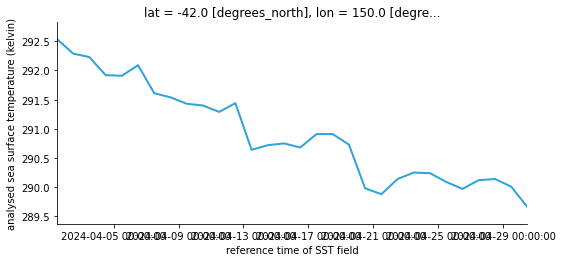

In [20]:
%%time
mds[sst_var].sel(lat=-42, lon=150, method="nearest").hvplot()

### Another example

A more detailed example of working with similar data in Zarr format can be found here: https://github.com/aodn/rimrep-examples/blob/main/Python_based_scripts/zarr.ipynb

# Other methods

## Zarr & Parquet
New cloud-optimised formats, covered in Loz's tutorial.

## ERDDAP
* Supports searching, subsetting, and downloads in a wide range of formats
* [Example](https://ioos.github.io/ioos_code_lab/content/code_gallery/data_access_notebooks/2016-10-12-fetching_data.html?highlight=erddap)
* Also covered in [this OHW22 tutorial](https://github.com/oceanhackweek/ohw-tutorials/blob/OHW22/01-Tue/00-data-access-in-python/00-data-access.ipynb)

## New OGC APIs
* [New standards](https://ogcapi.ogc.org/#standards) from the Open Geospatial Consortium
* OGC Features (replacement for WFS) - [example](https://github.com/aodn/rimrep-examples/blob/main/Python_based_scripts/ogcfeatures.ipynb)
* OGC Coverages [example](https://github.com/aodn/rimrep-examples/blob/main/Python_based_scripts/ogccoverages.ipynb)

## OGC Web Map Service (WMS)
* Also covered in [this OHW22 tutorial](https://github.com/oceanhackweek/ohw-tutorials/blob/OHW22/01-Tue/00-data-access-in-python/00-data-access.ipynb)

## Further resources
* Lots of data access examples at [IOOS CodeLab](https://ioos.github.io/ioos_code_lab/content/code_gallery/data_access.html)
* Examples in both Python and R from [Great Barrier Reef Data Management System](https://github.com/aodn/rimrep-examples)